In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm

from surprise import Dataset
from surprise import Reader
from surprise import NMF

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Ponemos una semilla fija para que el experimento sea reusable
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

# Calculo Factorización de Matrices

En este notebook entrenaremos la factorización de matrices aplicando el algoritmo **NMF**. Una vez entrenado, ya tendremos la matriz $P$ (relaciona usuario con las dimensiones) y la matriz $Q$ (relaciona películas con dimensiones). Al final, en la carpeta `data/matrices_data` tendremos la matriz $Q_u$ de cada usuario. Esto es la matriz $Q$ multiplicada por el vector en $P$ de cada usuario.

# Preparar dataset

Separaremos los datos de los ratings en 2 grupos, entrenamiento (que tendrá el 90% de los datos) y evaluación (que tendrá el 10% de los datos).

In [2]:
def train_test_split(dataDF, training_percentage):
    '''
    Función que divide el dataset en un conjunto de entrenamiento y
    otro conjunto de evaluación.
    '''
    msk = np.random.rand(len(dataDF)) < float(training_percentage / 100)
    train = dataDF[msk]
    test = dataDF[~msk]
    
    return train, test    

In [3]:
# Cargamos todos los ratings del experimento
ratings_DF = pd.read_csv('data/experiment_data/ratings.csv')
ratings_DF.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,6,4.0,964982224
2,1,47,5.0,964983815
3,1,50,5.0,964982931
4,1,110,4.0,964982176


In [4]:
# Calculamos el porcentaje de la matriz completado

num_users = len(ratings_DF.groupby('userId').count().index)
num_items = len(ratings_DF.groupby('movieId').count().index)
total_ratings = len(ratings_DF)
total_values_to_predict = num_users * num_items

print(100*(total_ratings / total_values_to_predict), '% ratings conocidos del total de la matriz')

36.358333333333334 % ratings conocidos del total de la matriz


In [5]:
# Preparamos el dataset de entrenamiento y evaluación
trainset, testset = train_test_split(ratings_DF, 90)

# Guardamos ambos dataframes en CSV
trainset.to_csv('data/experiment_data/trainset.csv', index=False)
testset.to_csv('data/experiment_data/testset.csv', index=False)

## Entrenamiento del algoritmo

Del nuevo dataset que hemos creado, calculamos las matrices P y Q usando el algoritmode NMF definido en la librería surprise.

In [6]:
# Cargamos los datasets
trainset_DF = pd.read_csv('data/experiment_data/trainset.csv', usecols=[0,1,2])
testset_DF = pd.read_csv('data/experiment_data/testset.csv', usecols=[0,1,2])

# Preparamos los datos de entrenamiento y evaluación

reader = Reader(rating_scale=(1,5))

train_data = Dataset.load_from_df(trainset_DF, reader).build_full_trainset()
test_data = Dataset.load_from_df(testset_DF, reader).build_full_trainset().build_testset()

# Seleccionamos el algoritmo
recommendation_algorithm = NMF()

# Entrenamos el algoritmo
recommendation_algorithm.fit(train_data)

# Obetenmos las predicciones
predictions = recommendation_algorithm.test(test_data)

# Mostramos las predicciones
predictions_df = pd.DataFrame(predictions, columns=['userId', 'movieId', 'realRating', 'estRating', 'details']).drop(columns='details')
predictions_df.head()

,userId,movieId,realRating,estRating
0,1,235,4.0,4.048087
1,1,356,4.0,4.698501
2,1,590,4.0,4.344254
3,1,780,3.0,3.830231
4,1,1206,5.0,4.728964


## Calculamos las matrices $Q_u$

A continuación, calculamos las matrices $Q_u$ de cada usuario y lo guardamos en ficheros CSV.

In [7]:
# Obtenemos las matrices P y Q
p = pd.DataFrame(recommendation_algorithm.pu)
p['userId'] = sorted(list(set(trainset_DF['userId'])))
p.set_index('userId',inplace=True)
p.reset_index(inplace=True)

q = recommendation_algorithm.qi

In [8]:
# Por cada usuario calculamos su Qu y la gaurdamos en un CSV

for u in tqdm(range(len(p))):
    user_id = int(p.loc[u]['userId'])
    user_vector = p.loc[u][1:].values

    q_u = user_vector * q
    q_u_df = pd.DataFrame(q_u)
    q_u_df['movieId'] = sorted(list(set(trainset_DF['movieId'])))
    q_u_df.set_index('movieId', inplace=True)
    q_u_df.reset_index(inplace=True)
    
    path = 'data/matrices_data/q_user_' + str(user_id) + '.csv'
    q_u_df.to_csv(path, index=False)

100%|██████████| 200/200 [00:02<00:00, 89.90it/s]


# Calcular la predicción de ratings a partir de Qu

In [15]:
def get_predicted_rating(row):
    user = int(row['userId'])
    movie = int(row['movieId'])
    
    q_u = pd.read_csv('data/matrices_data/q_user_' + str(user) + '.csv')
    values = q_u[q_u['movieId'] == movie].values[0]
    return np.sum(values[1:])

In [16]:
testset_DF['predicted'] = testset_DF.apply(lambda row: get_predicted_rating(row), axis=1)
testset_DF.head()

In [19]:
testset_DF.to_csv('data/experiment_data/predicted_values.csv', index=False)

## Visualizar matrices

En esta sección se pueden visualizar las matrices $Q_u$. Se muestra un mapa de calor de la matriz y un analisis estádistico de cada uno de los factores de la matriz $Q_u$. 

In [11]:
# Seleccionar el usuario que vamos a mostrar
user_id = 462
path = 'data/matrices_data/q_user_' + str(user_id) + '.csv'

In [12]:
q_u_DF = pd.read_csv(path)
q_u_DF.head()

,movieId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1,0.055519,0.284300,0.071296,0.175175,0.121276,0.078223,0.277798,0.416717,0.111132,0.244173,0.112360,0.015296,0.367116,0.337531,0.200480
1,2,0.063254,0.233811,0.116422,0.104513,0.285195,0.022775,0.383299,0.336096,0.105489,0.076063,0.113991,0.027909,0.402202,0.308158,0.361106
2,6,0.050458,0.136966,0.093492,0.233309,0.054313,0.041937,0.808441,0.737594,0.031724,0.289528,0.163341,0.011110,0.331561,0.223922,0.359196
3,10,0.049755,0.454384,0.137553,0.159934,0.182977,0.064257,0.665322,0.543518,0.136596,0.272374,0.134118,0.019486,0.071971,0.191383,0.262978
4,11,0.071014,0.292693,0.175471,0.129106,0.127298,0.039662,0.760651,0.711359,0.074961,0.140513,0.105493,0.024862,0.273273,0.120511,0.187550


In [13]:
q_u_describe = q_u_DF.describe()
q_u_describe

,movieId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,8570.030000,0.058402,0.216939,0.131479,0.140297,0.184534,0.053069,0.471937,0.376454,0.100310,0.214663,0.109391,0.020231,0.255953,0.228535,0.262733
std,19230.981427,0.026117,0.106299,0.061876,0.070889,0.085957,0.027829,0.250540,0.181100,0.044917,0.108190,0.051382,0.009040,0.123868,0.105322,0.125564
min,1.000000,0.001391,0.000071,0.001454,0.000464,0.004127,0.000901,0.005686,0.006183,0.000898,0.001192,0.001907,0.000631,0.002976,0.002043,0.005493
25%,586.750000,0.041828,0.138323,0.085189,0.089678,0.121734,0.032194,0.280555,0.247420,0.072080,0.134719,0.075586,0.013988,0.166675,0.155353,0.177504
50%,1582.000000,0.060798,0.224382,0.130592,0.134219,0.185367,0.051966,0.441702,0.379620,0.099335,0.212076,0.109022,0.019839,0.251166,0.235166,0.250731
75%,4250.000000,0.078411,0.290666,0.174512,0.189164,0.249281,0.070389,0.666317,0.511670,0.131522,0.281386,0.145588,0.026177,0.335864,0.297695,0.346920
max,109487.000000,0.150395,0.545653,0.319940,0.346894,0.420234,0.151258,1.202167,0.828467,0.226955,0.661956,0.309281,0.045792,0.565744,0.513824,0.744261


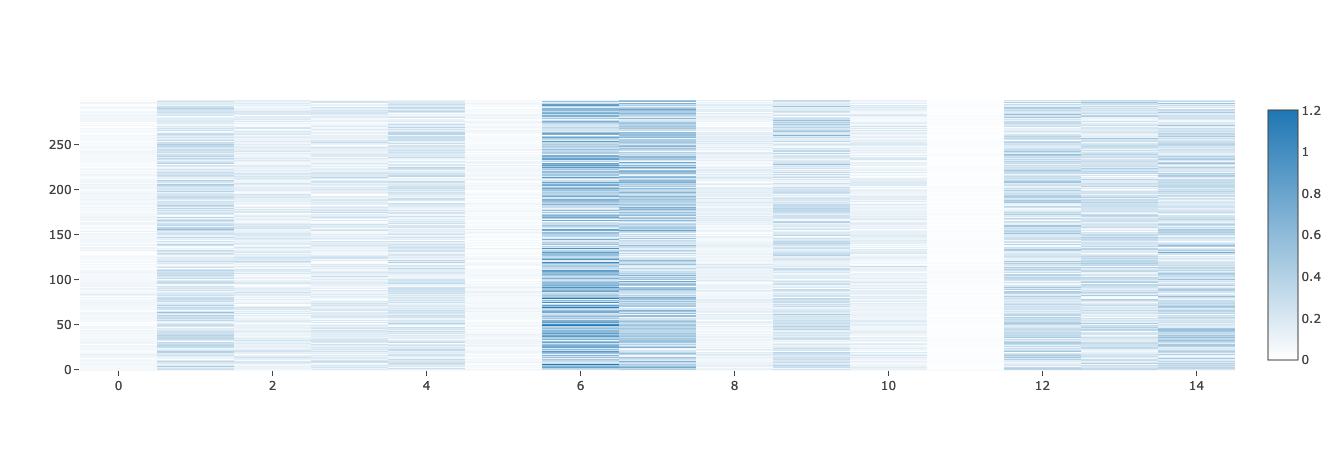

In [14]:
trace = go.Heatmap(z=q_u_DF.iloc[:,1:].values,
                   x=q_u_DF.columns[1:].values,
                   y=q_u_DF.index.values,
                   colorscale=[[0.0, 'rgb(255,255,255)'], [1.0, 'rgb(31, 119, 180)']])

data=[trace]
iplot(data, filename='labelled-heatmap')

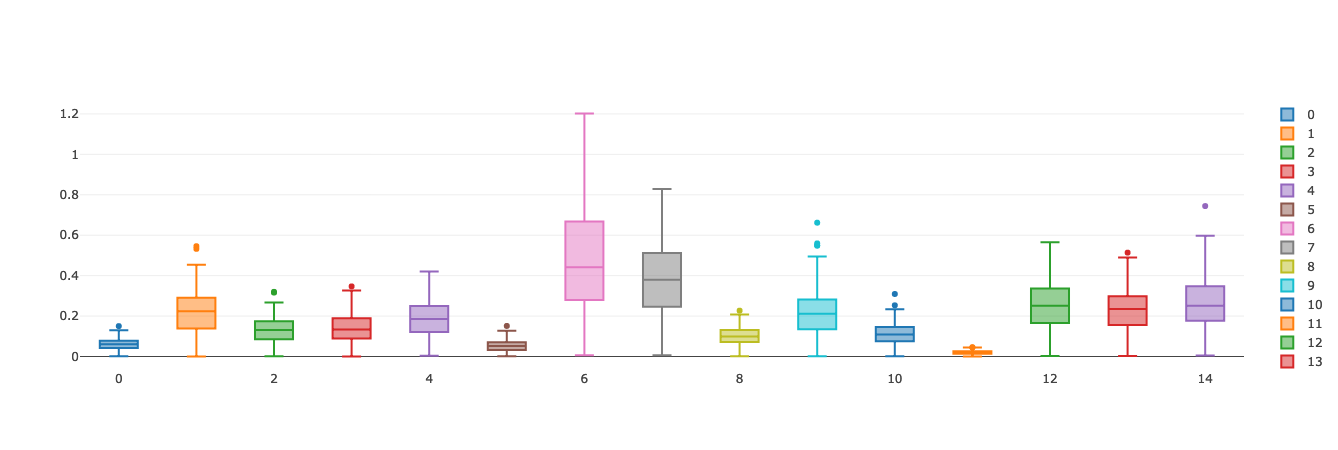

In [15]:
aux = q_u_DF.drop(columns=['movieId']).transpose()
data = []
for i in range(len(aux)):
    trace = go.Box(
        y = aux.iloc[i,:].values,
        name = str(i)
    )

    data.append(trace)

iplot(data)

### Siguiente Notebook

Una vez calculado las matrices $Q$ por cada usuario ya podemos obtener películas similares a partir de esa información y estudiar las características en común. Ejecute el notebook `recomendador_con_explicaciones.ipynb`.